In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("light-novel-titles.csv")
df["title_word_count"] = df.titles.apply(lambda x: len(str(x).split()))
df.head()

,titles,descriptions,genres,links,title_word_count
0,Thereafter of an Exiled Magician ~Somehow My E...,"Lain, a reincarnated person, lives his life as...","['Action', 'Adventure', 'Ecchi', 'Fantasy', 'H...",https://www.novelupdates.com/series/thereafter...,33
1,Mahoutsukai no Konyakusha (LN),I who was reincarnated into a world of sword a...,"['Action', 'Drama', 'Fantasy', 'Harem', 'Matur...",https://www.novelupdates.com/series/mahoutsuka...,4
2,Exiled Prince Without Skills: Infinite Growth ...,"Henry, born in a royal family without skills, ...","['Action', 'Adventure', 'Fantasy', 'Horror', '...",https://www.novelupdates.com/series/exiled-pri...,10
3,Reincarnation Of The Strongest Sword God,"Starting over once more, he has entered this “...","['Action', 'Fantasy', 'Martial Arts', 'School ...",https://www.novelupdates.com/series/reincarnat...,6
4,Hard Work Will Never Betray Me (LN),A youth whose effort wasn’t rewarded lost his ...,"['Action', 'Adventure', 'Fantasy']",https://www.novelupdates.com/series/hard-work-...,7


In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace("(LN)", "")
    text = re.sub(r'[^\w\s]','',text)
    return str(text)

In [4]:
text_df = df.titles[df["title_word_count"] > 4] # get rid of short titles
text = text_df.apply(preprocess_text).to_numpy() 

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

total_words = len(tokenizer.word_index) + 1

input_sequences = []
for title in text:
    token_list = tokenizer.texts_to_sequences([title])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
model = keras.Sequential()
model.add(keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(150)))
model.add(keras.layers.Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(xs, ys, epochs=55, verbose=1)

Epoch 1/55
229/229 [==============================] - 46s 185ms/step - loss: 6.8648 - accuracy: 0.0550
Epoch 2/55
229/229 [==============================] - 42s 183ms/step - loss: 6.2835 - accuracy: 0.0634
Epoch 3/55
229/229 [==============================] - 41s 180ms/step - loss: 5.9730 - accuracy: 0.0832
Epoch 4/55
229/229 [==============================] - 41s 179ms/step - loss: 5.6046 - accuracy: 0.1009
Epoch 5/55
229/229 [==============================] - 41s 180ms/step - loss: 5.2590 - accuracy: 0.1170
Epoch 6/55
229/229 [==============================] - 41s 180ms/step - loss: 4.9311 - accuracy: 0.1364
Epoch 7/55
229/229 [==============================] - 41s 178ms/step - loss: 4.6143 - accuracy: 0.1597
Epoch 8/55
229/229 [==============================] - 41s 181ms/step - loss: 4.3183 - accuracy: 0.1813
Epoch 9/55
229/229 [==============================] - 41s 180ms/step - loss: 4.0420 - accuracy: 0.2039
Epoch 10/55
229/229 [==============================] - 41s 178ms/step - l

In [7]:
# serialize the model to disk
#DOWNLOAD ONLY IF YOU WANT TO
#NOTE: ONLY CAN DOWNLOAD AFTER YOU'VE RUN CELL ABOVE. Might take around 45min to train the model. Or go to my github to download directly
print("[INFO] saving isekai title model...")
model.save('isekai_title_maker', save_format="h5")

[INFO] saving isekai title model...


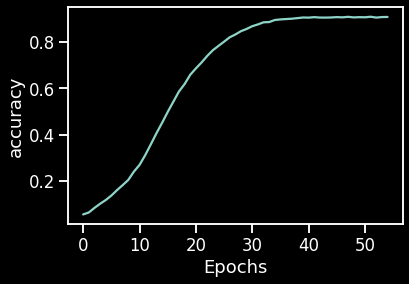

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", context="talk")
plt.style.use('dark_background') 
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, "accuracy")

In [9]:
def generate_text(seed_text, next_words=10):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(model.predict(token_list), axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return(seed_text)

In [10]:
generate_text("the incompetent hero", 30)

'the incompetent hero who has been banished wants to hide his abilities the strongest sage who reincarnated twice he wanted to enjoy this life so took it easy and was banished from the'

In [11]:
generate_text("i", 25)

'i was a small fish when i reincarnated but it seems that i can become a dragon so i will do my best to build a'

In [12]:
generate_text("living a slow life in", 30)

'living a slow life in a different world and become extraordinary even in the real world ln are the unique skill smoke ruler and level up i am i was driven out to be going'

In [13]:
generate_text("Cheat", 15)

'Cheat in a different world with a smartphone treasure i cant accept this life and live'